In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch.nn as nn
from torchvision.models import mobilenet_v2

class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Classifier, self).__init__()
        # Load the pretrained MobileNetV2 model
        self.model = mobilenet_v2(pretrained=True)
        # Replace the final classifier layer to match the number of classes
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [8]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [9]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [11]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [13]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=4ccc58680c20047d38f6f70d95c540d39fc6dd7d7842368833ad360efe30509c
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=fb89beacf0dfda9f752a54ee27da45298922ff6b1263ff05e9c67361d3fc330a
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = MobileNetV2Classifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()


        scheduler.step()

    return ensemble_models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s] 


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                       | #elements or shape   |
|:---------------------------|:---------------------|
| model                      | 2.2M                 |
|  module                    |  2.2M                |
|   module.model             |   2.2M               |
|    module.model.features   |    2.2M              |
|    module.model.classifier |    3.8K              |
Total FLOPs: 0.33 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Train Loss: 0.3131, Accuracy: 0.5765, Precision: 0.6416, Recall: 0.5765, F1 Score: 0.5987


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Validation Inference Time: 5.31 sec, Peak GPU Memory: 771.60 MB
Validation Loss: 0.2692, Accuracy: 0.7100, Precision: 0.6854, Recall: 0.7100, F1 Score: 0.6869
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.1870, Accuracy: 0.7970, Precision: 0.7890, Recall: 0.7970, F1 Score: 0.7759


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Validation Inference Time: 1.85 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2429, Accuracy: 0.7433, Precision: 0.7327, Recall: 0.7433, F1 Score: 0.7303
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Train Loss: 0.1556, Accuracy: 0.8625, Precision: 0.8588, Recall: 0.8625, F1 Score: 0.8563


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Validation Inference Time: 1.83 sec, Peak GPU Memory: 780.56 MB
Validation Loss: 0.2351, Accuracy: 0.7533, Precision: 0.7497, Recall: 0.7533, F1 Score: 0.7497
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.1346, Accuracy: 0.9035, Precision: 0.9030, Recall: 0.9035, F1 Score: 0.8997


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Validation Inference Time: 1.84 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2421, Accuracy: 0.7300, Precision: 0.7235, Recall: 0.7300, F1 Score: 0.7260
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.1178, Accuracy: 0.9565, Precision: 0.9562, Recall: 0.9565, F1 Score: 0.9561


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2468, Accuracy: 0.7300, Precision: 0.7202, Recall: 0.7300, F1 Score: 0.7227
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Train Loss: 0.1056, Accuracy: 0.9815, Precision: 0.9816, Recall: 0.9815, F1 Score: 0.9814


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Validation Inference Time: 1.86 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2450, Accuracy: 0.7367, Precision: 0.7350, Recall: 0.7367, F1 Score: 0.7349
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0977, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2550, Accuracy: 0.7417, Precision: 0.7362, Recall: 0.7417, F1 Score: 0.7377
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0928, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2571, Accuracy: 0.7350, Precision: 0.7260, Recall: 0.7350, F1 Score: 0.7296
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Train Loss: 0.0903, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2570, Accuracy: 0.7333, Precision: 0.7300, Recall: 0.7333, F1 Score: 0.7304
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0881, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2468, Accuracy: 0.7417, Precision: 0.7358, Recall: 0.7417, F1 Score: 0.7383
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0868, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2511, Accuracy: 0.7467, Precision: 0.7422, Recall: 0.7467, F1 Score: 0.7437
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0856, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2464, Accuracy: 0.7467, Precision: 0.7424, Recall: 0.7467, F1 Score: 0.7440
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0848, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2455, Accuracy: 0.7283, Precision: 0.7277, Recall: 0.7283, F1 Score: 0.7277
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0832, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2458, Accuracy: 0.7300, Precision: 0.7317, Recall: 0.7300, F1 Score: 0.7307
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Train Loss: 0.0832, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2478, Accuracy: 0.7267, Precision: 0.7259, Recall: 0.7267, F1 Score: 0.7262
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.0823, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Validation Inference Time: 1.85 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2459, Accuracy: 0.7450, Precision: 0.7375, Recall: 0.7450, F1 Score: 0.7394
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Train Loss: 0.0812, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Validation Inference Time: 1.82 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2449, Accuracy: 0.7250, Precision: 0.7315, Recall: 0.7250, F1 Score: 0.7274
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Train Loss: 0.0808, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.86 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2463, Accuracy: 0.7267, Precision: 0.7304, Recall: 0.7267, F1 Score: 0.7278
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0795, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2416, Accuracy: 0.7250, Precision: 0.7238, Recall: 0.7250, F1 Score: 0.7243
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0790, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Validation Inference Time: 1.80 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2406, Accuracy: 0.7283, Precision: 0.7319, Recall: 0.7283, F1 Score: 0.7300
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Train Loss: 0.0785, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2382, Accuracy: 0.7267, Precision: 0.7296, Recall: 0.7267, F1 Score: 0.7280
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0778, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.86 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2352, Accuracy: 0.7367, Precision: 0.7323, Recall: 0.7367, F1 Score: 0.7343
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0772, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2360, Accuracy: 0.7350, Precision: 0.7293, Recall: 0.7350, F1 Score: 0.7317
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0766, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2364, Accuracy: 0.7217, Precision: 0.7207, Recall: 0.7217, F1 Score: 0.7210
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0755, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2336, Accuracy: 0.7300, Precision: 0.7286, Recall: 0.7300, F1 Score: 0.7293
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Train Loss: 0.0753, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2332, Accuracy: 0.7317, Precision: 0.7290, Recall: 0.7317, F1 Score: 0.7300
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Train Loss: 0.0743, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Validation Inference Time: 1.83 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2316, Accuracy: 0.7233, Precision: 0.7235, Recall: 0.7233, F1 Score: 0.7233
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0738, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Validation Inference Time: 1.86 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2313, Accuracy: 0.7267, Precision: 0.7262, Recall: 0.7267, F1 Score: 0.7261
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.0730, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2290, Accuracy: 0.7400, Precision: 0.7341, Recall: 0.7400, F1 Score: 0.7366
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.0725, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Validation Inference Time: 1.84 sec, Peak GPU Memory: 781.18 MB
Validation Loss: 0.2285, Accuracy: 0.7333, Precision: 0.7284, Recall: 0.7333, F1 Score: 0.7304
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Test Inference Time: 1.86 sec, Peak GPU Memory: 790.14 MB
Test Loss: 0.2123, Accuracy: 0.7533, Precision: 0.7497, Recall: 0.7533, F1 Score: 0.7497
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       117
           1       0.84      0.86      0.85       393
           2       0.58      0.68      0.62        90

    accuracy                           0.75       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.75      0.75      0.75       600



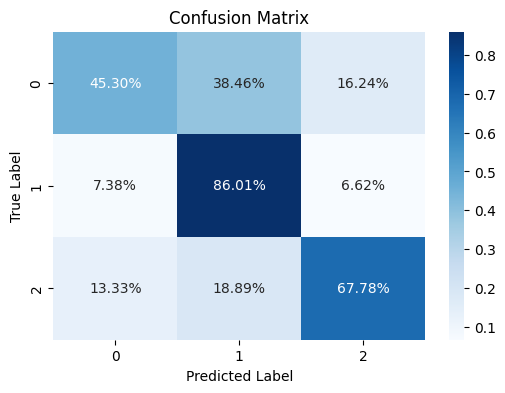

Test Sensitivity: 0.9210, Test Specificity: 0.5408


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


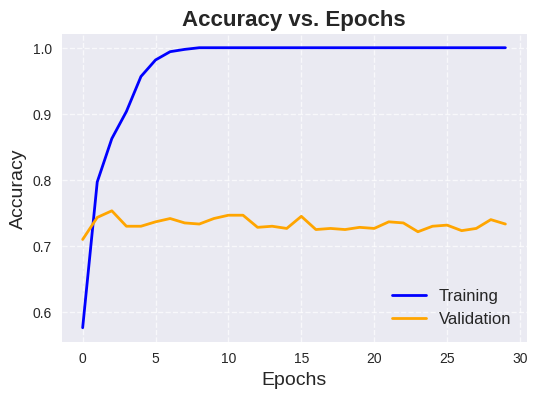

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


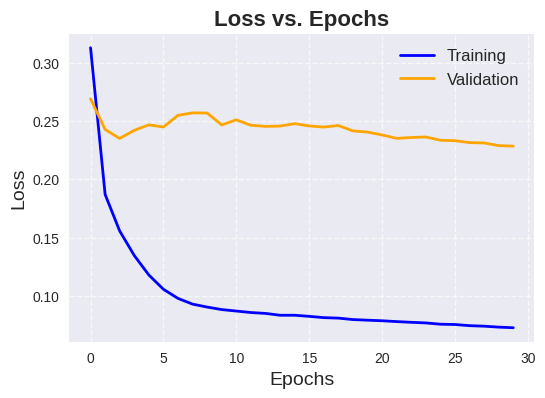

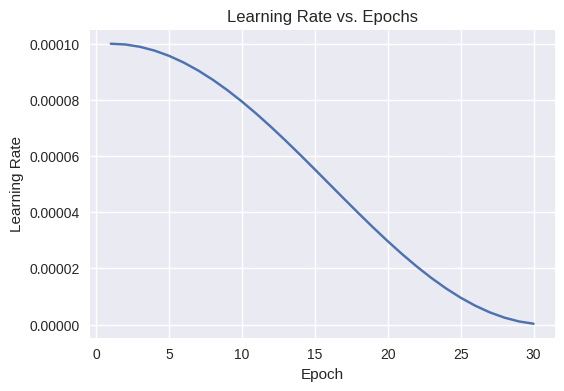

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.1268, Accuracy: 0.8910, Precision: 0.8894, Recall: 0.8910, F1 Score: 0.8873


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2298, Accuracy: 0.7200, Precision: 0.7144, Recall: 0.7200, F1 Score: 0.7153
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.0990, Accuracy: 0.9560, Precision: 0.9557, Recall: 0.9560, F1 Score: 0.9556


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2456, Accuracy: 0.7200, Precision: 0.7032, Recall: 0.7200, F1 Score: 0.7027
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0842, Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2383, Accuracy: 0.7333, Precision: 0.7278, Recall: 0.7333, F1 Score: 0.7297
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0770, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Validation Inference Time: 1.91 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2350, Accuracy: 0.7167, Precision: 0.7236, Recall: 0.7167, F1 Score: 0.7186
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0736, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2305, Accuracy: 0.7350, Precision: 0.7336, Recall: 0.7350, F1 Score: 0.7331
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0716, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2296, Accuracy: 0.7317, Precision: 0.7311, Recall: 0.7317, F1 Score: 0.7311
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0705, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2301, Accuracy: 0.7350, Precision: 0.7308, Recall: 0.7350, F1 Score: 0.7321
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0689, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Validation Inference Time: 1.83 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2251, Accuracy: 0.7283, Precision: 0.7281, Recall: 0.7283, F1 Score: 0.7281
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0680, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2215, Accuracy: 0.7383, Precision: 0.7328, Recall: 0.7383, F1 Score: 0.7334
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0669, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2239, Accuracy: 0.7250, Precision: 0.7281, Recall: 0.7250, F1 Score: 0.7263
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0667, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2157, Accuracy: 0.7317, Precision: 0.7324, Recall: 0.7317, F1 Score: 0.7320
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0656, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Validation Inference Time: 2.10 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2145, Accuracy: 0.7400, Precision: 0.7328, Recall: 0.7400, F1 Score: 0.7344
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0649, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2129, Accuracy: 0.7283, Precision: 0.7228, Recall: 0.7283, F1 Score: 0.7250
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0643, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.91 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2150, Accuracy: 0.7200, Precision: 0.7181, Recall: 0.7200, F1 Score: 0.7177
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0630, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Validation Inference Time: 2.00 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2151, Accuracy: 0.7233, Precision: 0.7212, Recall: 0.7233, F1 Score: 0.7209
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Train Loss: 0.0624, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2134, Accuracy: 0.7283, Precision: 0.7268, Recall: 0.7283, F1 Score: 0.7275
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0616, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Validation Inference Time: 1.84 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2102, Accuracy: 0.7333, Precision: 0.7301, Recall: 0.7333, F1 Score: 0.7306
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0609, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2110, Accuracy: 0.7233, Precision: 0.7238, Recall: 0.7233, F1 Score: 0.7223
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0600, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2069, Accuracy: 0.7400, Precision: 0.7333, Recall: 0.7400, F1 Score: 0.7360
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0596, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2053, Accuracy: 0.7450, Precision: 0.7375, Recall: 0.7450, F1 Score: 0.7397
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0586, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2046, Accuracy: 0.7417, Precision: 0.7328, Recall: 0.7417, F1 Score: 0.7357
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0578, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2024, Accuracy: 0.7450, Precision: 0.7325, Recall: 0.7450, F1 Score: 0.7365
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0572, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Validation Inference Time: 1.83 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2009, Accuracy: 0.7500, Precision: 0.7430, Recall: 0.7500, F1 Score: 0.7449
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0565, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Validation Inference Time: 1.82 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2008, Accuracy: 0.7283, Precision: 0.7261, Recall: 0.7283, F1 Score: 0.7272
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Train Loss: 0.0557, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1994, Accuracy: 0.7267, Precision: 0.7254, Recall: 0.7267, F1 Score: 0.7260
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0550, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Validation Inference Time: 1.81 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.2010, Accuracy: 0.7200, Precision: 0.7200, Recall: 0.7200, F1 Score: 0.7196
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0541, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Validation Inference Time: 2.04 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1984, Accuracy: 0.7317, Precision: 0.7249, Recall: 0.7317, F1 Score: 0.7270
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0539, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1951, Accuracy: 0.7283, Precision: 0.7273, Recall: 0.7283, F1 Score: 0.7277
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0528, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Validation Inference Time: 1.83 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1940, Accuracy: 0.7333, Precision: 0.7310, Recall: 0.7333, F1 Score: 0.7318
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0523, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1950, Accuracy: 0.7350, Precision: 0.7292, Recall: 0.7350, F1 Score: 0.7307
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0514, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1905, Accuracy: 0.7367, Precision: 0.7330, Recall: 0.7367, F1 Score: 0.7342
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0510, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1925, Accuracy: 0.7333, Precision: 0.7315, Recall: 0.7333, F1 Score: 0.7318
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0500, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Validation Inference Time: 1.91 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1914, Accuracy: 0.7333, Precision: 0.7302, Recall: 0.7333, F1 Score: 0.7310
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0493, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1901, Accuracy: 0.7250, Precision: 0.7264, Recall: 0.7250, F1 Score: 0.7255
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0486, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Validation Inference Time: 1.88 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1873, Accuracy: 0.7433, Precision: 0.7395, Recall: 0.7433, F1 Score: 0.7408
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Train Loss: 0.0478, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1869, Accuracy: 0.7350, Precision: 0.7294, Recall: 0.7350, F1 Score: 0.7314
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Train Loss: 0.0473, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Validation Inference Time: 2.00 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1856, Accuracy: 0.7400, Precision: 0.7333, Recall: 0.7400, F1 Score: 0.7354
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Train Loss: 0.0467, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Validation Inference Time: 2.22 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1840, Accuracy: 0.7417, Precision: 0.7350, Recall: 0.7417, F1 Score: 0.7372
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0456, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1842, Accuracy: 0.7483, Precision: 0.7410, Recall: 0.7483, F1 Score: 0.7421
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0451, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 791.29 MB
Validation Loss: 0.1807, Accuracy: 0.7400, Precision: 0.7321, Recall: 0.7400, F1 Score: 0.7349
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Test Inference Time: 1.95 sec, Peak GPU Memory: 800.00 MB
Test Loss: 0.1724, Accuracy: 0.7533, Precision: 0.7497, Recall: 0.7533, F1 Score: 0.7497
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       117
           1       0.84      0.86      0.85       393
           2       0.58      0.68      0.62        90

    accuracy                           0.75       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.75      0.75      0.75       600



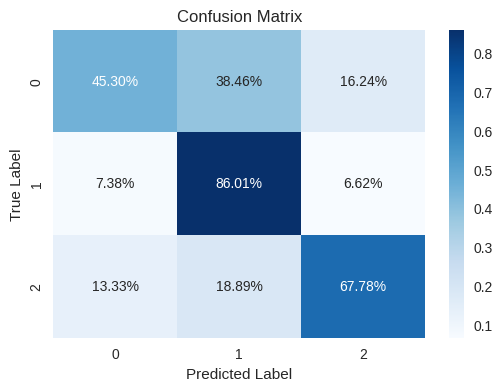

Test Sensitivity: 0.9210, Test Specificity: 0.5408


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


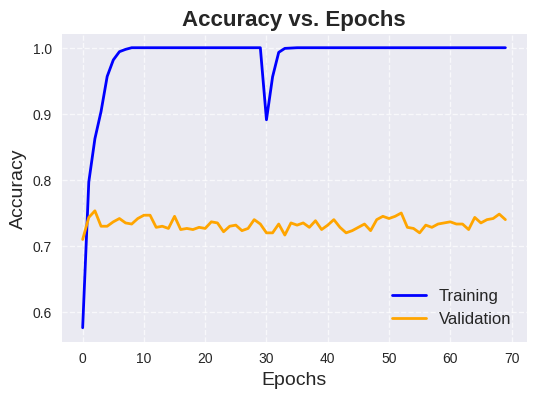

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


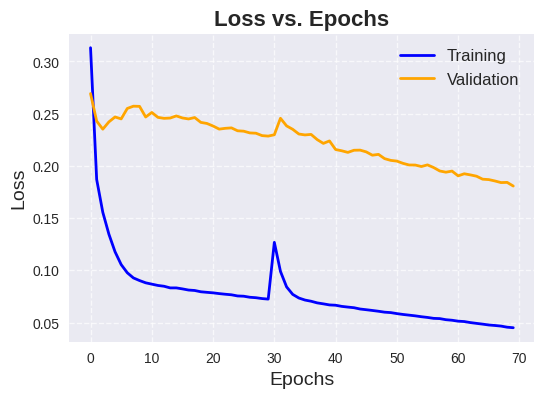

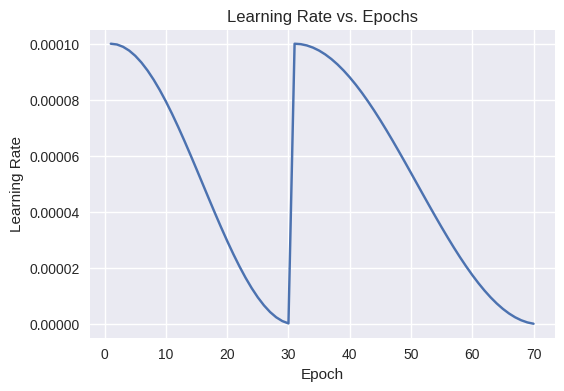

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Train Loss: 0.1036, Accuracy: 0.8775, Precision: 0.8747, Recall: 0.8775, F1 Score: 0.8745


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Validation Inference Time: 1.98 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1786, Accuracy: 0.7300, Precision: 0.7210, Recall: 0.7300, F1 Score: 0.7246
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


Train Loss: 0.0729, Accuracy: 0.9505, Precision: 0.9505, Recall: 0.9505, F1 Score: 0.9497


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Validation Inference Time: 1.97 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1821, Accuracy: 0.7533, Precision: 0.7395, Recall: 0.7533, F1 Score: 0.7373
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0576, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1952, Accuracy: 0.7233, Precision: 0.7250, Recall: 0.7233, F1 Score: 0.7241
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0497, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1936, Accuracy: 0.7450, Precision: 0.7376, Recall: 0.7450, F1 Score: 0.7402
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0460, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1946, Accuracy: 0.7333, Precision: 0.7321, Recall: 0.7333, F1 Score: 0.7311
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0444, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1918, Accuracy: 0.7283, Precision: 0.7317, Recall: 0.7283, F1 Score: 0.7276
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0425, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Validation Inference Time: 2.04 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1840, Accuracy: 0.7350, Precision: 0.7246, Recall: 0.7350, F1 Score: 0.7280
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0411, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1867, Accuracy: 0.7367, Precision: 0.7328, Recall: 0.7367, F1 Score: 0.7338
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0399, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1853, Accuracy: 0.7317, Precision: 0.7286, Recall: 0.7317, F1 Score: 0.7287
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Train Loss: 0.0391, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1801, Accuracy: 0.7283, Precision: 0.7270, Recall: 0.7283, F1 Score: 0.7276
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0382, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1810, Accuracy: 0.7233, Precision: 0.7284, Recall: 0.7233, F1 Score: 0.7256
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0373, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Validation Inference Time: 1.86 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1800, Accuracy: 0.7250, Precision: 0.7280, Recall: 0.7250, F1 Score: 0.7253
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0365, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Validation Inference Time: 2.00 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1776, Accuracy: 0.7317, Precision: 0.7318, Recall: 0.7317, F1 Score: 0.7315
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0353, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Validation Inference Time: 2.10 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1789, Accuracy: 0.7250, Precision: 0.7289, Recall: 0.7250, F1 Score: 0.7267
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0342, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1730, Accuracy: 0.7333, Precision: 0.7302, Recall: 0.7333, F1 Score: 0.7301
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Train Loss: 0.0335, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.02 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1721, Accuracy: 0.7350, Precision: 0.7285, Recall: 0.7350, F1 Score: 0.7313
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0328, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Validation Inference Time: 2.09 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1712, Accuracy: 0.7283, Precision: 0.7195, Recall: 0.7283, F1 Score: 0.7230
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0319, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Validation Inference Time: 2.02 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1704, Accuracy: 0.7367, Precision: 0.7310, Recall: 0.7367, F1 Score: 0.7330
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Train Loss: 0.0309, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.02 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1678, Accuracy: 0.7417, Precision: 0.7402, Recall: 0.7417, F1 Score: 0.7406
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Train Loss: 0.0303, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 798.91 MB
Validation Loss: 0.1646, Accuracy: 0.7600, Precision: 0.7485, Recall: 0.7600, F1 Score: 0.7514
Best model updated based on validation accuracy
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


Train Loss: 0.0294, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Validation Inference Time: 1.98 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1676, Accuracy: 0.7300, Precision: 0.7300, Recall: 0.7300, F1 Score: 0.7299
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0284, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1623, Accuracy: 0.7467, Precision: 0.7413, Recall: 0.7467, F1 Score: 0.7435
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Train Loss: 0.0278, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Validation Inference Time: 2.01 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1596, Accuracy: 0.7450, Precision: 0.7402, Recall: 0.7450, F1 Score: 0.7421
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


Train Loss: 0.0267, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Validation Inference Time: 2.21 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1615, Accuracy: 0.7483, Precision: 0.7443, Recall: 0.7483, F1 Score: 0.7446
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Train Loss: 0.0259, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Validation Inference Time: 2.08 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1598, Accuracy: 0.7333, Precision: 0.7270, Recall: 0.7333, F1 Score: 0.7295
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0253, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Validation Inference Time: 1.97 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1620, Accuracy: 0.7367, Precision: 0.7336, Recall: 0.7367, F1 Score: 0.7345
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Train Loss: 0.0242, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1590, Accuracy: 0.7333, Precision: 0.7287, Recall: 0.7333, F1 Score: 0.7306
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0235, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1614, Accuracy: 0.7317, Precision: 0.7338, Recall: 0.7317, F1 Score: 0.7319
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0224, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Validation Inference Time: 1.97 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1584, Accuracy: 0.7417, Precision: 0.7360, Recall: 0.7417, F1 Score: 0.7376
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Train Loss: 0.0216, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Validation Inference Time: 2.02 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1565, Accuracy: 0.7433, Precision: 0.7370, Recall: 0.7433, F1 Score: 0.7397
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Train Loss: 0.0210, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1555, Accuracy: 0.7500, Precision: 0.7382, Recall: 0.7500, F1 Score: 0.7419
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0199, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1548, Accuracy: 0.7483, Precision: 0.7401, Recall: 0.7483, F1 Score: 0.7431
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0190, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Validation Inference Time: 1.87 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1564, Accuracy: 0.7367, Precision: 0.7319, Recall: 0.7367, F1 Score: 0.7329
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Train Loss: 0.0181, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1566, Accuracy: 0.7250, Precision: 0.7306, Recall: 0.7250, F1 Score: 0.7275
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Train Loss: 0.0171, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1535, Accuracy: 0.7383, Precision: 0.7358, Recall: 0.7383, F1 Score: 0.7370
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Train Loss: 0.0161, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Validation Inference Time: 1.95 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1521, Accuracy: 0.7400, Precision: 0.7371, Recall: 0.7400, F1 Score: 0.7381
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


Train Loss: 0.0152, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1516, Accuracy: 0.7367, Precision: 0.7327, Recall: 0.7367, F1 Score: 0.7345
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0144, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1517, Accuracy: 0.7267, Precision: 0.7250, Recall: 0.7267, F1 Score: 0.7258
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0135, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1509, Accuracy: 0.7400, Precision: 0.7344, Recall: 0.7400, F1 Score: 0.7367
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Train Loss: 0.0127, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1528, Accuracy: 0.7367, Precision: 0.7406, Recall: 0.7367, F1 Score: 0.7385
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0117, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1506, Accuracy: 0.7400, Precision: 0.7336, Recall: 0.7400, F1 Score: 0.7355
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Train Loss: 0.0106, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1500, Accuracy: 0.7417, Precision: 0.7381, Recall: 0.7417, F1 Score: 0.7393
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0097, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1499, Accuracy: 0.7417, Precision: 0.7402, Recall: 0.7417, F1 Score: 0.7403
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Train Loss: 0.0087, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Validation Inference Time: 1.90 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1513, Accuracy: 0.7367, Precision: 0.7397, Recall: 0.7367, F1 Score: 0.7379
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Train Loss: 0.0076, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Validation Inference Time: 1.93 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1501, Accuracy: 0.7367, Precision: 0.7377, Recall: 0.7367, F1 Score: 0.7366
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Train Loss: 0.0068, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Validation Inference Time: 1.97 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1498, Accuracy: 0.7383, Precision: 0.7372, Recall: 0.7383, F1 Score: 0.7373
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


Train Loss: 0.0061, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1483, Accuracy: 0.7433, Precision: 0.7419, Recall: 0.7433, F1 Score: 0.7422
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Train Loss: 0.0049, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Validation Inference Time: 1.89 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1487, Accuracy: 0.7283, Precision: 0.7284, Recall: 0.7283, F1 Score: 0.7279
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0039, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Validation Inference Time: 1.84 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1494, Accuracy: 0.7350, Precision: 0.7357, Recall: 0.7350, F1 Score: 0.7351
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Train Loss: 0.0030, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Validation Inference Time: 2.08 sec, Peak GPU Memory: 798.80 MB
Validation Loss: 0.1492, Accuracy: 0.7333, Precision: 0.7375, Recall: 0.7333, F1 Score: 0.7351
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Test Inference Time: 2.06 sec, Peak GPU Memory: 808.38 MB
Test Loss: 0.1360, Accuracy: 0.7600, Precision: 0.7485, Recall: 0.7600, F1 Score: 0.7514
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.59      0.44      0.50       117
           1       0.82      0.88      0.85       393
           2       0.64      0.64      0.64        90

    accuracy                           0.76       600
   macro avg       0.68      0.65      0.66       600
weighted avg       0.75      0.76      0.75       600



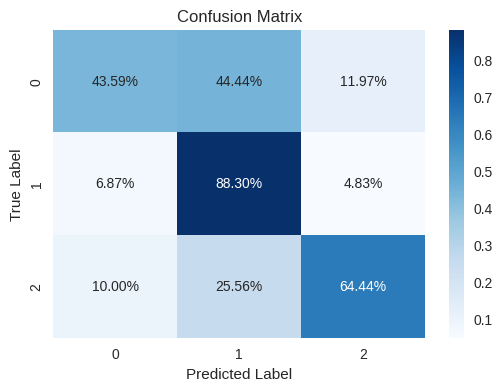

Test Sensitivity: 0.9278, Test Specificity: 0.4951


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


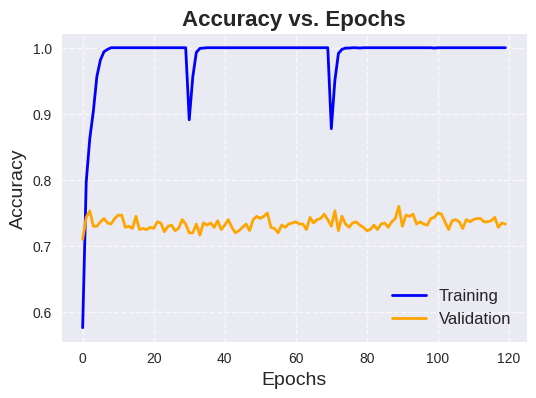

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


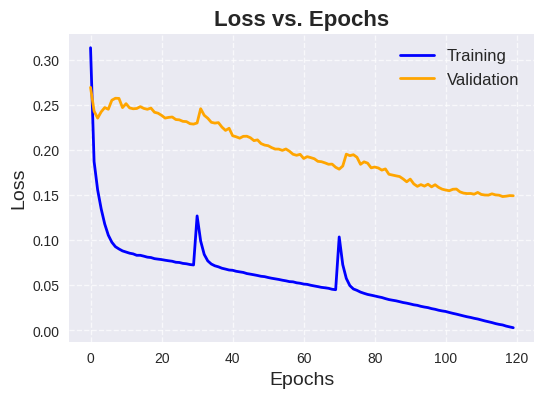

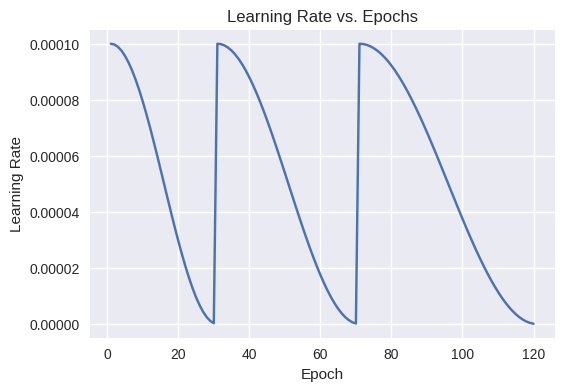

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)